<a href="https://colab.research.google.com/github/Lama-Aldhafeeri/CAMelBERT/blob/main/Training_CAMelBERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Setup

In [1]:
!pip install transformers
!pip install torch

In [2]:
!pip install python-bidi
!pip install arabic-reshaper

In [3]:
!pip install transformers camel-tools scikit-learn datasets matplotlib

## Read Dataset (Three labelds/classes)

In [4]:
import pandas as pd

dataset_url = 'https://raw.githubusercontent.com/Lama-Aldhafeeri/CAMelBERT/refs/heads/main/three_labeld_data_with_headers.csv'
df_original = pd.read_csv(dataset_url)
df_original.head()

,Post,Polarity
0,انتاج اهل تبوك طييييب الى الامام خوله لماذا_ي...,Pos
1,اهنيكي ياخوله لانك عشتي حياتك كماتريدين ولم ت...,Pos
2,اي والله لماذا انتي حلوه كذا لماذا_يا_خوله_ال...,Pos
3,جميله صراحه الله يوفقها لماذا_يا_خوله_العنزي,Pos
4,دعوا الخلق للخالق بس البنت قمه بالجمال لماذا_...,Pos


## Discover the dataset

In [5]:
df_original.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56662 entries, 0 to 56661
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Post      56662 non-null  object
 1   Polarity  56662 non-null  object
dtypes: object(2)
memory usage: 885.5+ KB


In [6]:
df_original.Polarity.value_counts()

,count
Polarity,
Neg,20727
Neut,18722
Pos,17213


##Mapping labels into numbers 0,1,2

In [7]:
df_original['Polarity'] = df_original['Polarity'].map({'Neg': 0, 'Neut': 1, 'Pos': 2})

## Cleaning

In [8]:
repeat = []  # Initialize an empty list

list_of_posts = df_original['Post'].to_list()  # Convert column to list.

for i in range(len(list_of_posts) - 1):  # Loop through list.
    if list_of_posts[i] in list_of_posts[i+1:]:  # Check for duplicates.
        repeat.append(i)  # Add index to list.
len(repeat)  # Return duplicates count.

15588

In [9]:
df_original.drop(repeat, axis=0, inplace=True)  # Drop duplicate rows.
len(df_original)  # Return new length.

41074

In [10]:
df_original.dropna(inplace=True)  # Drop null rows.
len(df_original)  # Return new length.

41074

In [11]:
df_original.reset_index(drop=True, inplace=True)  # Reset index
df_original.head()  # Display first 5 rows

,Post,Polarity
0,انتاج اهل تبوك طييييب الى الامام خوله لماذا_ي...,2
1,اهنيكي ياخوله لانك عشتي حياتك كماتريدين ولم ت...,2
2,اي والله لماذا انتي حلوه كذا لماذا_يا_خوله_ال...,2
3,جميله صراحه الله يوفقها لماذا_يا_خوله_العنزي,2
4,دعوا الخلق للخالق بس البنت قمه بالجمال لماذا_...,2


In [12]:
# generate (original) column to compare the changes with (Post) column
original = df_original['Post'].copy()
df_original['original'] = original

In [13]:
df_original['pre_clean_len'] = [len(t) for t in df_original.Post]  # Add column with post lengths
df_original.head()

,Post,Polarity,original,pre_clean_len
0,انتاج اهل تبوك طييييب الى الامام خوله لماذا_ي...,2,انتاج اهل تبوك طييييب الى الامام خوله لماذا_ي...,59
1,اهنيكي ياخوله لانك عشتي حياتك كماتريدين ولم ت...,2,اهنيكي ياخوله لانك عشتي حياتك كماتريدين ولم ت...,122
2,اي والله لماذا انتي حلوه كذا لماذا_يا_خوله_ال...,2,اي والله لماذا انتي حلوه كذا لماذا_يا_خوله_ال...,50
3,جميله صراحه الله يوفقها لماذا_يا_خوله_العنزي,2,جميله صراحه الله يوفقها لماذا_يا_خوله_العنزي,45
4,دعوا الخلق للخالق بس البنت قمه بالجمال لماذا_...,2,دعوا الخلق للخالق بس البنت قمه بالجمال لماذا_...,61


In [14]:
from pprint import pprint  # Import pprint for better formatting

data_dict = {
    'polarity': {
        'type': df_original.Polarity.dtype,  # Polarity data type
        'description': 'sentiment class - 0: negative, 1: positive, 2: neutral'  # Polarity description
    },
    'Post': {
        'type': df_original.Post.dtype,  # Post data type
        'description': 'post text'  # Post description
    },
    'pre_clean_len': {
        'type': df_original.pre_clean_len.dtype,  # pre_clean_len data type
        'description': 'length of the post before cleaning'  # pre_clean_len description
   },
    'dataset.shape': df_original.shape  # Dataset shape (rows, columns)
}


In [15]:
data_dict

{'polarity': {'type': dtype('int64'),
  'description': 'sentiment class - 0: negative, 1: positive, 2: neutral'},
 'Post': {'type': dtype('O'), 'description': 'post text'},
 'pre_clean_len': {'type': dtype('int64'),
  'description': 'length of the post before cleaning'},
 'dataset.shape': (41074, 4)}

In [16]:
# Data cleaning function definition

from nltk.tokenize import WordPunctTokenizer
tok = WordPunctTokenizer()

In [17]:
import re  # Import regex module
from bs4 import BeautifulSoup  # Import BeautifulSoup for HTML parsing
import numpy as np  # Import NumPy for handling NaN values

# Define regex patterns
pat1 = r'@[A-Za-z0-9_]+'  # Pattern for mentions
pat2 = r'https?://[^ ]+'  # Pattern for URLs
combined_pat = r'|'.join((pat1, pat2))  # Combine patterns for mentions and URLs
www_pat = r'www.[^ ]+'  # Pattern for 'www' links
arabic_num_pat = '[٠١٢٣٤٥٦٧٨٩]'  # Pattern for Arabic numbers
eng_num_pat = '[0123456789]'  # Pattern for English numbers
sharta_pat = '[_]'  # Pattern for underscores
eng_pat = '[A-Za-z]'  # Pattern for English letters

def post_cleaner(text):  # Define function to clean posts
    soup = BeautifulSoup(text, 'lxml')  # Parse HTML content
    souped = soup.get_text()  # Get text from parsed HTML
    try:
        bom_removed = souped.encode("utf-8-sig").decode("utf-8")  # Remove byte order mark
    except Exception as e:
        bom_removed = souped  # Fallback if no BOM
        print(f"Error decoding: {e}")  # Print any decoding error

    # Apply regex substitutions
    stripped = re.sub(combined_pat, '', bom_removed)  # Remove mentions and URLs
    stripped = re.sub(www_pat, '', stripped)  # Remove 'www' links
    stripped = re.sub(arabic_num_pat, '', stripped)  # Remove Arabic numbers
    stripped = re.sub(eng_num_pat, '', stripped)  # Remove English numbers
    stripped = re.sub(sharta_pat, ' ', stripped)  # Replace underscores with spaces
    stripped = re.sub(eng_pat, ' ', stripped)  # Remove English letters

    # Tokenize and filter
    words = [x for x in stripped.split() if len(x) > 1]  # Tokenize and filter short words

    cleaned_text = " ".join(words).strip()  # Join cleaned words into a single string

    return cleaned_text  # Return cleaned text

In [18]:
clean_post_texts = []  # Initialize list to store cleaned posts

for i in range(0, len(df_original)):  # Loop through each row in the dataframe
  if (i + 1) % 10000 == 0:  # Check if the index is a multiple of 10,000
        print("Posts %d of %d has been processed" % (i + 1, len(df_original)))  # Print progress
  clean_post_texts.append(post_cleaner(df_original['Post'][i]))  # Clean the post and append to the list

Posts 10000 of 41074 has been processed
Posts 20000 of 41074 has been processed
Posts 30000 of 41074 has been processed
Posts 40000 of 41074 has been processed


In [19]:
len(clean_post_texts)

41074

## Save Clean Data

In [20]:
#save cleaned dataset just in case
clean_df = pd.DataFrame(clean_post_texts, columns=['text'])
clean_df['label'] = df_original.Polarity
clean_df['original'] = original
clean_df.to_csv('clean_post.csv', encoding='utf-8')

In [21]:
csv = 'clean_post.csv'
df = pd.read_csv(csv, index_col=0)

In [22]:
df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40755 entries, 0 to 40754
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   text      40755 non-null  object
 1   label     40755 non-null  int64 
 2   original  40755 non-null  object
dtypes: int64(1), object(2)
memory usage: 955.3+ KB


In [23]:
df.head()

,text,label,original
0,انتاج اهل تبوك طييييب الى الامام خوله لماذا يا...,2,انتاج اهل تبوك طييييب الى الامام خوله لماذا_ي...
1,اهنيكي ياخوله لانك عشتي حياتك كماتريدين ولم تك...,2,اهنيكي ياخوله لانك عشتي حياتك كماتريدين ولم ت...
2,﻿اي والله لماذا انتي حلوه كذا لماذا يا خوله ال...,2,اي والله لماذا انتي حلوه كذا لماذا_يا_خوله_ال...
3,﻿جميله صراحه الله يوفقها لماذا يا خوله العنزي,2,جميله صراحه الله يوفقها لماذا_يا_خوله_العنزي
4,﻿دعوا الخلق للخالق بس البنت قمه بالجمال لماذا ...,2,دعوا الخلق للخالق بس البنت قمه بالجمال لماذا_...



# Auto-generated SW and remove SW



In [24]:
#specify variable for each column
x = df.text
y = df.label
z = df.original

In [25]:
#discovering the most frequent words in the dataset (the order based on the total)
from sklearn.feature_extraction.text import CountVectorizer
cvec = CountVectorizer() # matrix of tokens count
cvec.fit(x)
neg_doc_matrix = cvec.transform(df[y ==0].text)
pos_doc_matrix = cvec.transform(df[y ==1].text)
neut_doc_matrix = cvec.transform(df[y ==2].text)

neg_tf = np.sum(neg_doc_matrix, axis=0)
pos_tf = np.sum(pos_doc_matrix, axis=0)
neut_tf = np.sum(neut_doc_matrix, axis=0)
word = cvec.get_feature_names_out()
neg = np.squeeze(np.asarray(neg_tf))
pos = np.squeeze(np.asarray(pos_tf))
neut = np.squeeze(np.asarray(neut_tf))

term_freq_df = pd.DataFrame([word, neg, pos, neut], columns= cvec.get_feature_names_out()).transpose()

term_freq_df.columns = ['word','negative', 'positive', 'neutral']
term_freq_df['total']=term_freq_df['negative'] + term_freq_df['positive'] + term_freq_df['neutral']
freq = term_freq_df.sort_values(by='total', ascending=False).iloc[:86024]

freq

,word,negative,positive,neutral,total
في,في,4845,7118,4023,15986
من,من,4026,2812,3383,10221
الهلال,الهلال,4,12,9990,10006
السعوديه,السعوديه,3236,2220,1020,6476
الدراسه,الدراسه,1306,4241,830,6377
...,...,...,...,...,...
سلوكيات,سلوكيات,0,1,0,1
سلوكياتنا,سلوكياتنا,1,0,0,1
سلوى,سلوى,1,0,0,1
سليمه,سليمه,1,0,0,1


In [26]:
#count the number of characters in one of posts(to see the changes after removing autogenerated stopwords)
old_length= len(df['text'][0])
old_length

58

In [27]:
df['text'][0]

'انتاج اهل تبوك طييييب الى الامام خوله لماذا يا خوله العنزي'

In [28]:
#put each column from the table in a list
words = freq['word'].to_list()
negative = freq['negative'].to_list()
positive = freq['positive'].to_list()
neutral = freq['neutral'].to_list()

final_labels = []

In [29]:
#classify each word in the dataset to positive negative or neutral based on its occurence in the dataset
for i in range(len(words)):
    if (negative[i]-positive[i]>=5) and (negative[i]-neutral[i]>=5):#if the word repeated in negative tweets more than positive and neutral tweets (5 and more) then the word is negative regardless the actual classification
        final_labels.append('negative')
    elif (positive[i]-negative[i]>=5) and (positive[i]-neutral[i]>=5):#if the word repeated in positive tweets more than negative and neutral tweets (5 and more) then the word is positive regardless the actual classification
        final_labels.append('positive')
    elif (neutral[i]-positive[i]>=5) and (neutral[i]-negative[i]>=5):#if the word repeated in neutral tweets more than positive and negative tweets (5 and more) then the word is neutral regardless the actual classification
        final_labels.append('neutral')
    elif (positive[i]==0 and neutral[i]==0):#if the occurence or words for neutral and positive ara 0, then for sure the word is negative regardless the actual classification
        final_labels.append('negative')
    elif (neutral[i]==0 and negative[i]==0):#if the occurence or words for neutral and negative ara 0, then for sure the word is positive regardless the actual classification
        final_labels.append('positive')
    elif (positive[i]==0 and negative[i]==0):#if the occurence or words for positive and negative ara 0, then for sure the word is neutral regardless the actual classification
        final_labels.append('neutral')
    else:
        final_labels.append('null')#if non of these condition are met (means the same word are occured the same for three classes(or the difference are 4 or less)) then the word is null

In [30]:
freq['Polarity'] = final_labels #check the labels for each word
final_labels[0:5]

['positive', 'negative', 'neutral', 'negative', 'positive']

In [31]:
len(words)

73784

In [32]:
len(final_labels)#the length of words (previos command) and final labels are same then no word is messing

73784

In [33]:
freq_null=freq[freq['Polarity']=='null']#collect all words with null classification as noisy words because dont affect the tweets when we remove them

In [34]:
null_words = freq_null['word'].to_list()#put null words to list

In [35]:
len(null_words) #no. of null words

15518

In [36]:
null_words[0]#sample of null word

'اذا'

In [37]:
with open('null_words.txt', 'a', encoding='utf-8') as f: #save null words in text file to be used as stopwords
    for ele in null_words:
        f.write(ele+'\n')

with open('null_words.txt','r',encoding='utf-8') as f:
    list_of_words = f.readlines()

clean_list=[]
for ele in list_of_words:
    clean_list.append(ele.rstrip('\n'))


In [38]:
#apply stopword removal on the dataset
def remove_words(st):
    tokens=st.split()
    new = []
    for word in tokens:
        if word not in clean_list:
            new.append(word)
    return ' '.join(new)

df['text']=df['text'].apply(remove_words)

In [39]:
#check the character length for one tweet (past:105)
new_length=len(df['text'][0])
new_length

43

In [40]:
# Import CAMeL tools for normalization and dediacritization
from camel_tools.utils.normalize import normalize_alef_ar, normalize_alef_maksura_ar, normalize_teh_marbuta_ar
from camel_tools.utils.dediac import dediac_ar

# Define a function to preprocess the posts (normalize and dediacritize)
def normalize_arabic(post):
    # Normalize alef variants to 'ا'
    post = normalize_alef_ar(post)
    # Normalize alef maksura 'ى' to yeh 'ي'
    post = normalize_alef_maksura_ar(post)
    # Normalize teh marbuta 'ة' to heh 'ه'
    post = normalize_teh_marbuta_ar(post)
    # Remove diacritics
    post = dediac_ar(post)
    return post

for i in range(len(clean_post_texts)):  # Loop through each cleaned post
  clean_post_texts[i] = normalize_arabic(clean_post_texts[i])  # Normalize each post's Arabic text

# Save Data After Preprocessing

In [41]:
clean_df = pd.DataFrame(clean_post_texts, columns=['text'])
clean_df['label'] = df_original.Polarity
clean_df.to_csv('Preprocessed_posts.csv', encoding='utf-8')

In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

%matplotlib inline
%config InlinBackend.figure_format = 'retina'

In [43]:
csv = 'Preprocessed_posts.csv'
df_clean = pd.read_csv(csv, index_col=0)
df_clean.head()

,text,label
0,انتاج اهل تبوك طييييب الي الامام خوله لماذا يا...,2
1,اهنيكي ياخوله لانك عشتي حياتك كماتريدين ولم تك...,2
2,﻿اي والله لماذا انتي حلوه كذا لماذا يا خوله ال...,2
3,﻿جميله صراحه الله يوفقها لماذا يا خوله العنزي,2
4,﻿دعوا الخلق للخالق بس البنت قمه بالجمال لماذا ...,2


In [44]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 41074 entries, 0 to 41073
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    40755 non-null  object
 1   label   41074 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 962.7+ KB


In [45]:
text=df_clean['text'].copy()
label = df_clean['label'].copy()
df= pd.DataFrame(text,columns=['text'])
df['label'] = label
df.head()

,text,label
0,انتاج اهل تبوك طييييب الي الامام خوله لماذا يا...,2
1,اهنيكي ياخوله لانك عشتي حياتك كماتريدين ولم تك...,2
2,﻿اي والله لماذا انتي حلوه كذا لماذا يا خوله ال...,2
3,﻿جميله صراحه الله يوفقها لماذا يا خوله العنزي,2
4,﻿دعوا الخلق للخالق بس البنت قمه بالجمال لماذا ...,2


In [46]:
df.dropna(inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 40755 entries, 0 to 41073
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    40755 non-null  object
 1   label   40755 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 955.2+ KB


In [47]:
df.label.value_counts()

,count
label,
2,16616
1,12341
0,11798


In [48]:
# Replace NaNs and empty strings with empty strings
df['text'] = df['text'].fillna('').astype(str)

In [49]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, classification_report
from datasets import Dataset
import torch
import numpy as np


df = df.reset_index(drop=True)

# Step 1: Split the data into training and test sets
train_texts, test_texts, train_labels, test_labels = train_test_split(
    df['text'].tolist(), df['label'].tolist(), test_size=0.2, random_state=42)

# Step 2: Load CAMeL-BERT tokenizer and model for sequence classification
model_name = 'CAMeL-Lab/bert-base-arabic-camelbert-da'
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=3)

# Step 3: Tokenize the dataset
def tokenize_data(texts):
    return tokenizer(texts, padding=True, truncation=True, max_length=128)

train_encodings = tokenize_data(train_texts)
test_encodings = tokenize_data(test_texts)

# Step 4: Create a Dataset object
train_dataset = Dataset.from_dict({
    'input_ids': train_encodings['input_ids'],
    'attention_mask': train_encodings['attention_mask'],
    'labels': train_labels
})

test_dataset = Dataset.from_dict({
    'input_ids': test_encodings['input_ids'],
    'attention_mask': test_encodings['attention_mask'],
    'labels': test_labels
})

# Step 5: Define the evaluation metrics
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='macro')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

# Step 6: Set up training arguments
training_args = TrainingArguments(
    output_dir='./results',                  # Output directory for model checkpoints
    evaluation_strategy='epoch',             # Evaluate after every epoch
    save_strategy='epoch',                   # Save model after every epoch
    learning_rate=3e-5,                      # Set the learning rate
    per_device_train_batch_size=16,          # Batch size for training
    per_device_eval_batch_size=16,           # Batch size for evaluation
    num_train_epochs=3,                      # Number of epochs
    weight_decay=0.01,                       # Weight decay for regularization
    logging_dir='./logs',                    # Log directory
    logging_steps=10,                        # Log every 10 steps
    load_best_model_at_end=True,             # Load best model at the end of training
    save_total_limit=2                       # Limit to saving two checkpoints to save disk space
)

# Step 7: Initialize the Trainer and fine-tune the model
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics
)

# Apply `contiguous()` to all model parameters
for param in model.parameters():
    param.data = param.data.contiguous()
trainer.train()

# Step 8: Evaluate the model on the test dataset
eval_results = trainer.evaluate()

# Step 9: Get predictions for the test set
predictions = trainer.predict(test_dataset)
preds = np.argmax(predictions.predictions, axis=1)

# Step 10: Compute the confusion matrix
cm = confusion_matrix(test_labels, preds)

label_mapping = {'Neg': 0, 'Neut': 1, 'Pos': 2}
class_report = classification_report(test_labels, preds, target_names=list(label_mapping.keys()))
print("Classification Report:")
print(class_report)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at CAMeL-Lab/bert-base-arabic-camelbert-da and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.240500,0.300482,0.888480,0.880870,0.881308,0.880927
2,0.119900,0.377458,0.894001,0.886533,0.887205,0.885931
3,0.036100,0.563004,0.892897,0.885502,0.885575,0.885493


Classification Report:
              precision    recall  f1-score   support

         Neg       0.84      0.87      0.86      2410
        Neut       0.86      0.82      0.84      2408
         Pos       0.95      0.95      0.95      3333

    accuracy                           0.89      8151
   macro avg       0.88      0.88      0.88      8151
weighted avg       0.89      0.89      0.89      8151



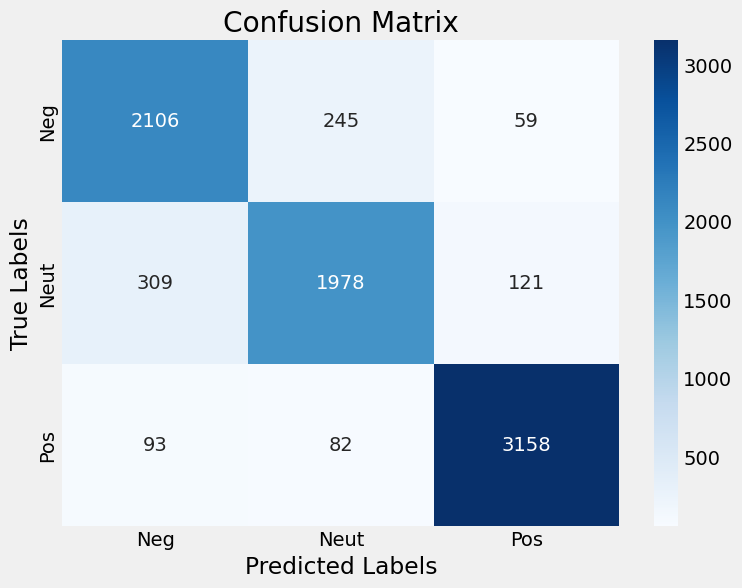

In [50]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot the confusion matrix
def plot_confusion_matrix(cm, labels):
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

plot_confusion_matrix(cm, labels=list(label_mapping.keys()))

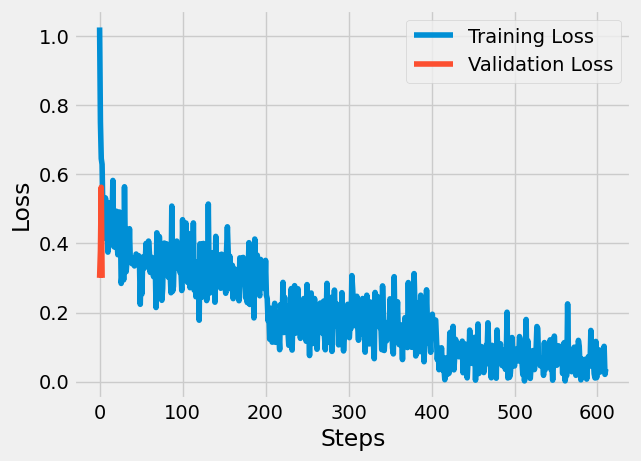

In [51]:
# Plot training and evaluation (validation) losses over time to monitor overfitting
losses = [log['loss'] for log in trainer.state.log_history if 'loss' in log]
eval_losses = [log['eval_loss'] for log in trainer.state.log_history if 'eval_loss' in log]

plt.plot(losses, label="Training Loss")
plt.plot(eval_losses, label="Validation Loss")
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [62]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments, EarlyStoppingCallback
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, classification_report
from datasets import Dataset
import torch
import numpy as np


df = df.reset_index(drop=True)

# Step 1: Split the data into training and test sets
train_texts, test_texts, train_labels, test_labels = train_test_split(
    df['text'].tolist(), df['label'].tolist(), test_size=0.2, random_state=42)

# Step 2: Load CAMeL-BERT tokenizer and model for sequence classification
model_name = 'CAMeL-Lab/bert-base-arabic-camelbert-da'
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=3)

# Step 3: Tokenize the dataset
def tokenize_data(texts):
    return tokenizer(texts, padding=True, truncation=True, max_length=128)

train_encodings = tokenize_data(train_texts)
test_encodings = tokenize_data(test_texts)

# Step 4: Create a Dataset object
train_dataset = Dataset.from_dict({
    'input_ids': train_encodings['input_ids'],
    'attention_mask': train_encodings['attention_mask'],
    'labels': train_labels
})

test_dataset = Dataset.from_dict({
    'input_ids': test_encodings['input_ids'],
    'attention_mask': test_encodings['attention_mask'],
    'labels': test_labels
})

# Step 5: Define the evaluation metrics
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='macro')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

# Step 6: Set up training arguments
training_args = TrainingArguments(
    output_dir='./results',
    evaluation_strategy='epoch',
    save_strategy='epoch',
    learning_rate=2e-5,                      # Optimized learning rate
    per_device_train_batch_size=16,          # Smaller batch size for better generalization
    per_device_eval_batch_size=16,
    num_train_epochs=5,                      # More epochs
    weight_decay=0.001,                      # Adjusted weight decay
    logging_dir='./logs',
    logging_steps=10,
    load_best_model_at_end=True,
    save_total_limit=2,
    warmup_steps=500,                        # Added warmup steps
    gradient_accumulation_steps=2,           # Gradient accumulation for larger batch size simulation

)

# Step 7: Initialize the Trainer and fine-tune the model
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
)

# Apply `contiguous()` to all model parameters
for param in model.parameters():
    param.data = param.data.contiguous()
trainer.train()

# Step 8: Evaluate the model on the test dataset
eval_results = trainer.evaluate()

# Step 9: Get predictions for the test set
predictions = trainer.predict(test_dataset)
preds = np.argmax(predictions.predictions, axis=1)

# Step 10: Compute the confusion matrix
cm32 = confusion_matrix(test_labels, preds)

label_mapping = {'Neg': 0, 'Neut': 1, 'Pos': 2}
class_report = classification_report(test_labels, preds, target_names=list(label_mapping.keys()))
print("Classification Report:")
print(class_report)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at CAMeL-Lab/bert-base-arabic-camelbert-da and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.308500,0.285774,0.885536,0.877594,0.877593,0.877651
2,0.204000,0.319254,0.892283,0.885033,0.885053,0.885676
3,0.132900,0.421620,0.894614,0.887133,0.888265,0.886590
4,0.026900,0.539880,0.896454,0.889234,0.889948,0.888934


Classification Report:
              precision    recall  f1-score   support

         Neg       0.86      0.85      0.85      2410
        Neut       0.83      0.84      0.83      2408
         Pos       0.95      0.95      0.95      3333

    accuracy                           0.89      8151
   macro avg       0.88      0.88      0.88      8151
weighted avg       0.89      0.89      0.89      8151



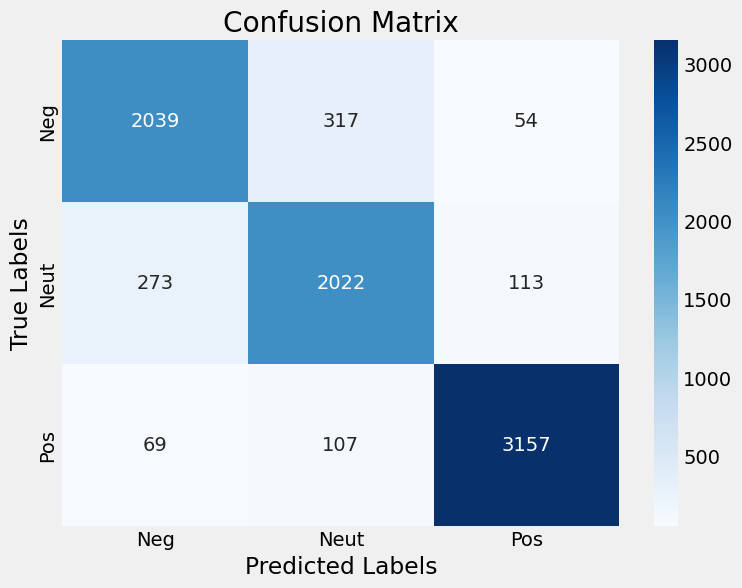

In [63]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot the confusion matrix
def plot_confusion_matrix(cm, labels):
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

plot_confusion_matrix(cm32, labels=list(label_mapping.keys()))